In [1]:
## Same as no-attention notebook with difference at model define

In [2]:
## Turn around camel-kenlm wheel error
!pip install -q future six docopt cachetools numpy scipy pandas scikit-learn torch transformers editdistance requests emoji pyrsistent muddler
!pip install -q camel-tools --no-deps
!pip install -q contractions  datasets

!pip install -q kaggle

In [3]:
from tqdm import tqdm
import time
from camel_tools.tokenizers.word import simple_word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import spacy
from collections import Counter
import random
import unicodedata
import pyarabic.araby as araby
import contractions
import nltk
from datasets import load_dataset
import re

In [4]:
lr = 1e-3
epochs = 15
valid_test_size = 0.4
# maxlen = 100 # length of one training sample by words
embd_features = 200 # length of embedding vectors for each word (input_size) (=1000 in paper)
batch_size = 128
max_freq = 2 # to add all words to the vocabulary that seen more than one time
lstm_hidden_size = 256 # The number of features in the hidden state (=1000 in paper)
lstm_layers = 4 # Number of stacked recurrent layers for encoder
dropout_p = 0.5

In [5]:
seed = 123
g = torch.Generator().manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

isKaggle = True
base_dir = '/kaggle/working' if isKaggle else '/content'

## Data

### Downloading

In [6]:
# # !wget -q https://www.manythings.org/anki/ara-eng.zip
# !kaggle datasets download -q samirmoustafa/arabic-to-english-translation-sentences
# !unzip '{base_dir}/arabic-to-english-translation-sentences.zip'

# !wget -q -O ./tatoeba.tsv https://drive.google.com/uc?id=1aO0yDI4-rDxD5J0OYAgVlUUQuMuqtFSD

# hf_dataset = load_dataset('Helsinki-NLP/tatoeba_mt','ara-eng', trust_remote_code=True)

ds = load_dataset("Helsinki-NLP/opus-100", "ar-en")

README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/214k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/99.3M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/979k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
# df_manythings = pd.read_csv(f'{base_dir}/ara_eng.txt', delimiter='\t', names=['EN_sentence',
#                                                                               'AR_sentence'])

# df_tatoeba = pd.read_csv(f'{base_dir}/tatoeba.tsv', delimiter='\t', names=['EN_id',
#                                                                         'EN_sentence',
#                                                                         'AR_id',
#                                                                         'AR_sentence']).drop(columns=['EN_id',
#                                                                                                       'AR_id'])
# df_hf_1, df_hf_2 = hf_dataset['test'], hf_dataset['validation']

# df_hf_1 = pd.DataFrame(df_hf_1)[['sourceString','targetString']]
# df_hf_1.columns = ['AR_sentence', 'EN_sentence']

# df_hf_2 = pd.DataFrame(df_hf_2)[['sourceString','targetString']]
# df_hf_2.columns = ['AR_sentence', 'EN_sentence']

# df_data = pd.concat([df_manythings, df_tatoeba, df_hf_1, df_hf_2], axis=0, ignore_index=True)
# df_data = df_data.reset_index(drop=True)

df_data = pd.DataFrame(ds['train']['translation']).rename(columns={'en': 'EN_sentence',
                                                                    'ar': 'AR_sentence',})

### Visualizing

In [8]:
df_data.sample(3, random_state=seed)

,AR_sentence,EN_sentence
373315,لا، الطفل هنا.,"No, kid's here."
459286,-أجل، حتى نقتل أحدهم بشكل غير مقصود,"Yes, till we inadvertently kill one of them."
262398,عرض ممثل اسبانيا مشروع القرار بالنيابة عن مقدم...,"The representative of Spain, on behalf of the ..."


In [9]:
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_ar(text):
    text = text.lower()
    text = unicodeToAscii(text)
    text = re.sub(r"([?.!؟،,¿])", r" \1 ", text)
    text = re.sub(r"[^؀-ۿ?.!,¿]+", " ", text)
    text = araby.strip_diacritics(text) # Remove diacritics "التشكيل"
    text = re.sub(r'\s+', ' ', text).strip() # Trim multiple whitespaces to one
    return text

def preprocess_en(text):
    text = text.lower()
    text = contractions.fix(text) # Fix contractions "it's" -> "it is"
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    text = re.sub(r'\s+', ' ', text).strip() # Trim multiple whitespaces to one
    return text


df_data['EN_sentence'] = df_data['EN_sentence'].apply(preprocess_en)
df_data['AR_sentence'] = df_data['AR_sentence'].apply(preprocess_ar)

In [10]:
df_data.sample(3, random_state=seed)

,AR_sentence,EN_sentence
373315,لا ، الطفل هنا .,"no , kid s here ."
459286,اجل ، حتى نقتل احدهم بشكل غير مقصود,"yes , till we inadvertently kill one of them ."
262398,عرض ممثل اسبانيا مشروع القرار بالنيابة عن مقدم...,"the representative of spain , on behalf of the..."


In [11]:
df_data['EN_sentence_length'] = df_data['EN_sentence'].apply(lambda x: len(x.split(' ')))
df_data['AR_sentence_length'] = df_data['AR_sentence'].apply(lambda x: len(x.split(' ')))

In [12]:
## Drop sentences that has length >= 100
df_data = df_data[(df_data['EN_sentence_length'] < 100) & (df_data['AR_sentence_length'] < 100)]

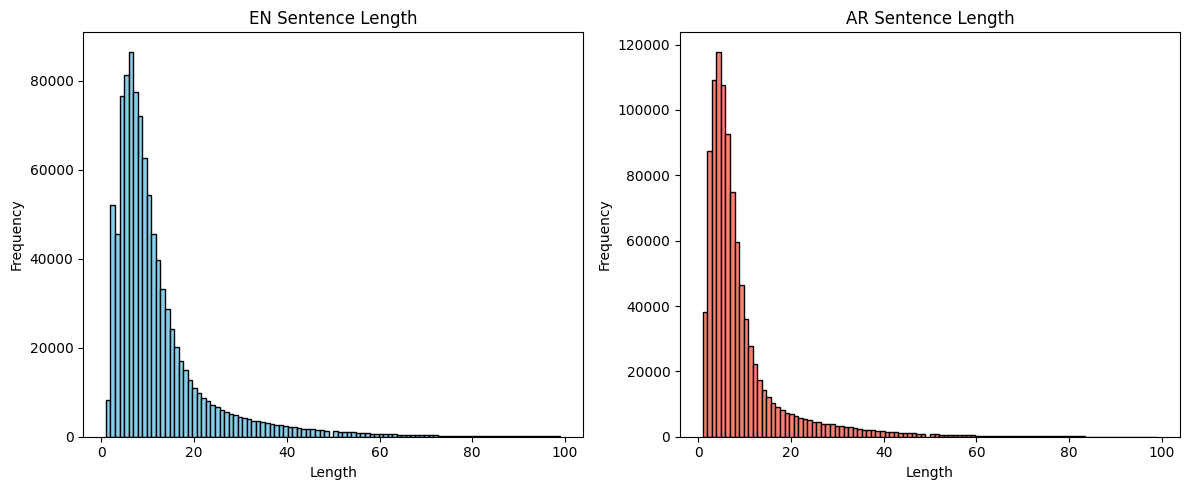

In [13]:
# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define custom tick range based on your data range
# EN_x_ticks = np.arange(0, df_data['EN_sentence_length'].max()+1, 100)
# AR_x_ticks = np.arange(0, df_data['AR_sentence_length'].max()+1, 100)

# Plot histogram for EN_sentence_length
axes[0].hist(df_data['EN_sentence_length'], bins=100, color='skyblue', edgecolor='black')
axes[0].set_title('EN Sentence Length')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')
# axes[0].set_xticks(EN_x_ticks)  # Add more x-axis ticks

# Plot histogram for AR_sentence_length
axes[1].hist(df_data['AR_sentence_length'], bins=100, color='salmon', edgecolor='black')
axes[1].set_title('AR Sentence Length')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')
# axes[1].set_xticks(AR_x_ticks)  # Add more x-axis ticks

# Display the plots
plt.tight_layout()
plt.show()

As we see there are long and too short sentences.

Short sentences will suffer from vanishing Gradients, As we will do post-padding (right-padding), so we will dorp short sentences.

### Cleaning

In [14]:
print(df_data.info())
df_data.describe()
## so Q3 at 14

<class 'pandas.core.frame.DataFrame'>
Index: 997996 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   AR_sentence         997996 non-null  object
 1   EN_sentence         997996 non-null  object
 2   EN_sentence_length  997996 non-null  int64 
 3   AR_sentence_length  997996 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 38.1+ MB
None


,EN_sentence_length,AR_sentence_length
count,997996.000000,997996.000000
mean,11.934556,8.967793
std,11.280625,9.736318
min,1.000000,1.000000
25%,5.000000,4.000000
50%,8.000000,6.000000
75%,14.000000,10.000000
max,99.000000,99.000000


In [15]:
indices_to_drop = []

idx = (df_data[(df_data['AR_sentence_length'].isin([1])) | 
                (df_data['EN_sentence_length'] == 1)]).index
indices_to_drop += list(idx)

idx = df_data[(df_data['EN_sentence_length'] > 15) | 
                (df_data['AR_sentence_length'] > 15)].index
indices_to_drop += list(idx)

idx = (df_data[(df_data['AR_sentence_length'].isin([2])) & 
               (df_data['EN_sentence_length'] > 7)]).index
indices_to_drop += list(idx)

idx = (df_data[(df_data['AR_sentence_length'].isin([3])) & 
               (df_data['EN_sentence_length'] > 12)]).index
indices_to_drop += list(idx)
indices_to_drop += list([100934, 101388, 100488, 79292]) ## Bad indices
indices_to_drop = list(set(indices_to_drop))

filtered_data = df_data.drop(indices_to_drop).reset_index(drop=True)

# df_data = df_data.drop_duplicates(keep='first', subset='AR_sentence')
filtered_data = filtered_data.drop_duplicates(keep='first', subset='EN_sentence')

filtered_data = filtered_data.replace('', pd.NA).dropna()
filtered_data = filtered_data.replace(' ', pd.NA).dropna()
filtered_data.isna().sum()

AR_sentence           0
EN_sentence           0
EN_sentence_length    0
AR_sentence_length    0
dtype: int64

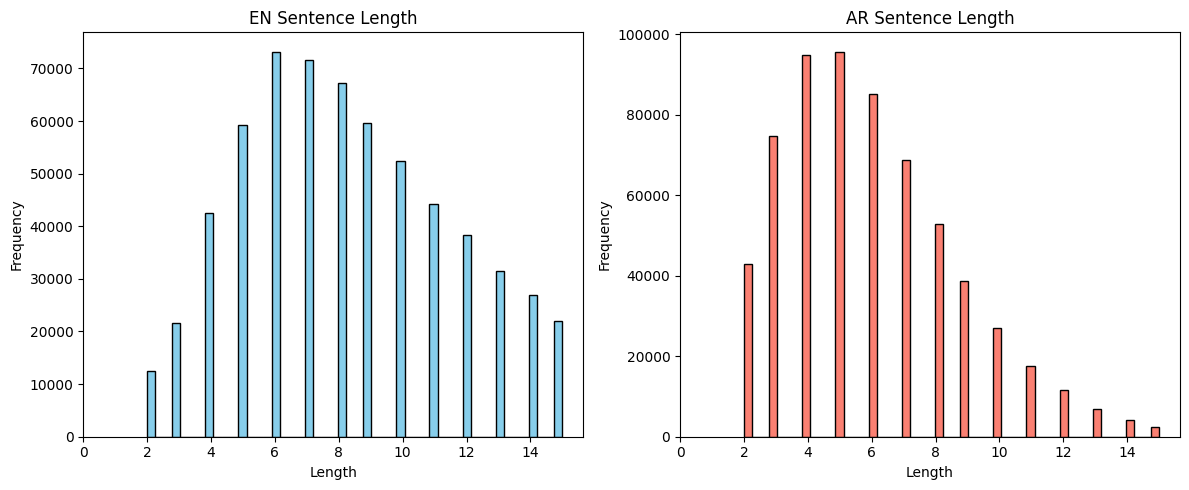

In [16]:
# Create a figure and two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define custom tick range based on your data range
EN_x_ticks = np.arange(0, filtered_data['EN_sentence_length'].max()+1, 2)
AR_x_ticks = np.arange(0, filtered_data['AR_sentence_length'].max()+1, 2)

# Plot histogram for EN_sentence_length
axes[0].hist(filtered_data['EN_sentence_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('EN Sentence Length')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(EN_x_ticks)  # Add more x-axis ticks

# Plot histogram for AR_sentence_length
axes[1].hist(filtered_data['AR_sentence_length'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('AR Sentence Length')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(AR_x_ticks)  # Add more x-axis ticks

# Display the plots
plt.tight_layout()
plt.show()

### Spliting

In [17]:
df_train, df_test = train_test_split(filtered_data, test_size=valid_test_size, shuffle=True, random_state=seed)
df_valid, df_test = train_test_split(df_test, test_size=0.5, shuffle=True, random_state=seed)

print(df_train.shape, df_test.shape, df_valid.shape, sep=', ')

(373765, 4), (124589, 4), (124588, 4)


### Loading and preprocessing (DataPipeline)

In [18]:
# Arabic Tokenizer
class camel_tokenizer():
    def __call__(self, text):
        return simple_word_tokenize(text)
        # return [tok.text.lower() for tok in simple_word_tokenize(text)]


# English Tokenizer
class spacy_tokenizer:
    def __init__(self):
        self.spacy_eng = spacy.load("en_core_web_sm", disable=["ner", "parser"])
        self.spacy_eng.max_length = 10**6

    def __call__(self, text):
        return [tok.text for tok in self.spacy_eng.tokenizer(text)]

    def batch_tokenize(self, texts):
        return [[tok.text for tok in doc] for doc in self.spacy_eng.pipe(texts, batch_size=256)]


In [19]:
class Vocabulary:
    def __init__(self, tokenizer, max_freq=3, unk=True, sos=False, eos=False):
        self.sos = sos
        self.eos = eos
        self.unk = unk
        self.tokenizer = tokenizer
        self.max_freq = max_freq

        self.stoi = {"<PAD>": 0}
        if unk: self.stoi['<UNK>'] = len(self.stoi)
        if sos: self.stoi['<SOS>'] = len(self.stoi)
        if eos: self.stoi['<EOS>'] = len(self.stoi)

    def __len__(self):
        return len(self.stoi)

    def get_vocabulary(self):
        return self.stoi

    def add_token(self, token_name: str):
        if token_name not in self.stoi:
            self.stoi[token_name] = len(self.stoi)

    def build_vocabulary(self, sentences_list):
        if isinstance(sentences_list[0], list):
            sentences_list = [' '.join(sentence) for sentence in sentences_list]

        if isinstance(self.tokenizer, spacy_tokenizer) and hasattr(self.tokenizer, 'batch_tokenize'):
            tokens_list = self.tokenizer.batch_tokenize(sentences_list)
        else:
            tokens_list = [self.tokenizer(sentence) for sentence in sentences_list]

        word_counts = Counter(token for tokens in tokens_list for token in tokens)
        filtered_words = [word for word, count in word_counts.items() if count >= self.max_freq]
        self.stoi.update({word: i+len(self.stoi) for i, word in enumerate(filtered_words)})

    def get_numerical_tokens(self, text):
        tokens = self.tokenizer(text)
        if self.sos: tokens.insert(0, '<SOS>')
        if self.eos: tokens.append('<EOS>')
        unk_id = self.stoi.get('<UNK>', None)
        return [self.stoi.get(token, unk_id) for token in tokens]

    def __call__(self, text):
        return self.get_numerical_tokens(text)

    def tokens_to_text(self, tokens_list):
        keys = list(self.stoi.keys())
        values = list(self.stoi.values())

        return ' '.join([keys[values.index(token)] for token in tokens_list])

In [20]:
class MT_Dataset(Dataset):

    def __init__(self, en_sentences_list, ar_sentences_list, en_vocabulary:Vocabulary, ar_vocabulary:Vocabulary):

        super(MT_Dataset, self).__init__()
        self.ar_sentences_list = ar_sentences_list
        self.en_sentences_list = en_sentences_list
        self.ar_vocabulary = ar_vocabulary
        self.en_vocabulary = en_vocabulary
        # self.maxlen = maxlen

    def __len__(self):
        return len(self.en_sentences_list)

    def __getitem__(self, index):
        en_sentence, ar_sentence = self.en_sentences_list[index], self.ar_sentences_list[index]

        en_numrical_tokens = self.en_vocabulary(en_sentence)
        ar_numrical_tokens = self.ar_vocabulary(ar_sentence)

        return torch.tensor(en_numrical_tokens), torch.tensor(ar_numrical_tokens)

In [21]:
class MYCollate():
    def __init__(self, batch_first=True, pad_value=0):
        self.pad_value = pad_value
        self.batch_first = batch_first

    def __call__(self, data):
        en_stentences = [ex[0] for ex in data]
        ar_stentences = [ex[1] for ex in data]

        padded_en_stentences = nn.utils.rnn.pad_sequence(en_stentences, batch_first=self.batch_first,
                                                      padding_value=self.pad_value)
        padded_ar_stentences = nn.utils.rnn.pad_sequence(ar_stentences, batch_first=self.batch_first,
                                                      padding_value=self.pad_value)
        return padded_en_stentences, padded_ar_stentences

In [22]:
en_tokenizer = spacy_tokenizer()
en_vocab = Vocabulary(en_tokenizer, max_freq=max_freq, unk=True, sos=True, eos=True)
en_vocab.build_vocabulary(df_train['EN_sentence'].values)
print(f'{len(en_vocab) = }')

ar_tokenizer = camel_tokenizer()
ar_vocab = Vocabulary(ar_tokenizer, max_freq=max_freq, unk=True, sos=True, eos=True)
ar_vocab.build_vocabulary(df_train['AR_sentence'].values)
print(f'{len(ar_vocab) = }')

len(en_vocab) = 30746
len(ar_vocab) = 68231


In [23]:
train_ds = MT_Dataset(df_train['EN_sentence'].values, df_train['AR_sentence'].values,
                          en_vocabulary=en_vocab, ar_vocabulary=ar_vocab)

valid_ds = MT_Dataset(df_valid['EN_sentence'].values, df_valid['AR_sentence'].values,
                          en_vocabulary=en_vocab, ar_vocabulary=ar_vocab)

test_ds = MT_Dataset(df_test['EN_sentence'].values, df_train['AR_sentence'].values,
                          en_vocabulary=en_vocab, ar_vocabulary=ar_vocab)

In [24]:
en_vocab.tokens_to_text(train_ds[4][0]), ar_vocab.tokens_to_text(train_ds[4][1])

('<SOS> marion , listen very closely . <EOS>',
 '<SOS> ماريون ، استمعي جيدا . <EOS>')

In [25]:
mycollate = MYCollate(batch_first=True, pad_value=0)
pin_memory = True if device == 'cuda' else False
num_workers = 4 if isKaggle else 2

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=mycollate, num_workers=num_workers,
                          generator=g, pin_memory=pin_memory)

valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,
                          collate_fn=mycollate, num_workers=num_workers,
                          generator=g, pin_memory=pin_memory)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         collate_fn=mycollate, num_workers=num_workers,
                         generator=g, pin_memory=pin_memory)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 18])
torch.Size([128, 15])


## Form Embedding matrices

### Ar.

In [26]:
ar_embedding_matrix = torch.rand((len(ar_vocab), embd_features))

### En.

In [27]:
en_embedding_matrix = torch.rand((len(en_vocab), embd_features))

In [28]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip

# with ZipFile(f'{base_dir}/glove.6B.zip') as file:
#     file.extract('glove.6B.100d.txt')

In [29]:
# # form an embedding matrix form glove pre-trained embedding weights for my vocab
# glove_embeddings_index = dict()
# en_embedding_matrix = torch.rand((len(en_vocab), embd_features))*0.1
# vocab_dict = en_vocab.get_vocabulary()
# found = 0

# with open('glove.6B.100d.txt') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]

#         # token = word_tokenizer.word_tokenizing(word, stemming=False)
#         token = word
#         if token:
#             # print(word)
#             idx = vocab_dict.get(token, 0)
#             if idx:
#                 found += 1
#                 coefs = torch.tensor([float(value) for value in values[1:]])
#                 en_embedding_matrix[idx] = coefs
#                 # glove_embeddings_index[word] = coefs

# print('Found %s words.' % found)
# print("Embedding matrix shape: ", en_embedding_matrix.shape)


In [30]:
for x, y in test_loader:
    print('Before Embedding layer', x.shape, y.shape, sep='\t\t')
    en_emb = en_embedding_matrix[x]
    ar_emb = ar_embedding_matrix[y]
    print('After Embedding layer\t', en_emb.shape, ar_emb.shape, sep='\t')
    break

Before Embedding layer		torch.Size([128, 17])		torch.Size([128, 15])
After Embedding layer		torch.Size([128, 17, 200])	torch.Size([128, 15, 200])


## Models: Defining, Training and Evaluation

In [31]:
class Encoder(nn.Module):
    def __init__(self, embd_matrix:torch.Tensor, pretrained:bool, lstm_hidden_size, lstm_layers=1, dropout_probability=0.1):
        super().__init__()
        self.hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.input_size = embd_matrix.size(-1)
        self.embd_layer = nn.Embedding.from_pretrained(embd_matrix, freeze=False) if pretrained else nn.Embedding(embd_matrix.size(0), embd_matrix.size(1))

        self.dropout = nn.Dropout(dropout_probability)
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.lstm_layers, dropout=dropout_probability, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size * 2, lstm_hidden_size)

    def forward(self, x):
        embds = self.dropout(self.embd_layer(x))
        output, hidden = self.gru(embds)
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # all_hidden = hidden
        hidden = torch.cat([hidden[-2,:,:], hidden[-1,:,:]], dim=1)
        hidden = torch.tanh(self.fc(hidden))

        return output, hidden

########################--------------------##################################
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[0]
        src_length = encoder_outputs.shape[1]
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        pre_energy = torch.cat((hidden, encoder_outputs), dim=2)
        energy = torch.tanh(self.attn_fc(pre_energy))
        
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

########################--------------------##################################
class Decoder(nn.Module):
    def __init__(self, embd_matrix:torch.Tensor, pretrained:bool, attention:Attention, lstm_hidden_size, lstm_layers=1, dropout_probability=0):
        super().__init__()
        self.hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.input_size = embd_matrix.size(-1)
        self.embd_layer = nn.Embedding.from_pretrained(embd_matrix, freeze=False) if pretrained else nn.Embedding(embd_matrix.size(0), embd_matrix.size(1))
        self.attention = attention

        self.dropout = nn.Dropout(dropout_probability)
        self.gru = nn.GRU((lstm_hidden_size * 2) + self.input_size, self.hidden_size, self.lstm_layers, dropout=dropout_probability, batch_first=True)
        self.fc_out = nn.Linear(self.hidden_size, embd_matrix.size(0))
        
    def forward(self, x, hidden_t_1, encoder_outputs):
        embds = self.dropout(self.embd_layer(x))
        a = self.attention(hidden_t_1, encoder_outputs)
        a = a.unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embds, weighted), dim=2)

        output, hidden_t = self.gru(rnn_input, hidden_t_1.unsqueeze(0))
        # embds = embds.squeeze(1)
        output = output.squeeze(1)
        # weighted = weighted.squeeze(1)
        # all_in_one = torch.cat((output, weighted, embds), dim=1)
        # prediction = self.fc_out(all_in_one)
        prediction = self.fc_out(output)
        
        return prediction, hidden_t.squeeze(0), a.squeeze(1)


########################--------------------##################################
class Seq2seq_with_attention(nn.Module):
    def __init__(self, encoder:Encoder, decoder:Decoder):
        super(Seq2seq_with_attention, self).__init__()

        self.decoder_vocab_size = decoder.embd_layer.weight.size(0)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):

        batch_size, seq_len = target.size()

        total_outputs = torch.zeros(batch_size, seq_len, self.decoder_vocab_size, device=source.device)

        encoder_outputs, hidden = self.encoder(source)

        x = target[:, [0]]
        for step in range(1, seq_len):
            logits, hidden, _ = self.decoder(x, hidden, encoder_outputs)
            
            total_outputs[:, step] = logits
            top1 = logits.argmax(1, keepdim=True)
            x = target[:, [step]] if teacher_force_ratio > random.random() else top1

        return total_outputs

    @torch.no_grad
    def translate(self, source:torch.Tensor, max_tries=50):
        output = [2] ## <SOS> token

        targets = torch.randint(0,1,(source.size(0), max_tries)).to(device=source.device)
        targets_hat = self.forward(source, targets, 0.0)
        targets_hat = targets_hat.argmax(-1).squeeze(0)
        for token in targets_hat[1:]:
            output.append(token.item())
            if token == 3:
                break

        return output

In [32]:
## Helper
@torch.no_grad()
def loss_acc_loader(model, data_loader, device, force=0.5):
    model.eval()

    total_predicts = []
    total_targets = []
    total_class_loss = 0

    for data, labels in data_loader:
        data = data.to(device)
        labels = labels.to(device)

        class_logits = model(data, labels, force)
        class_logits_flat = class_logits[:, 1:, :].reshape(-1, class_logits.size(-1))
        labels_flat = labels[:, 1:].reshape(-1)

        total_class_loss += class_criterion(class_logits_flat, labels_flat).item()

        predictions = class_logits_flat.argmax(-1)
        non_pad_mask = labels_flat != 0
        filtered_predictions = predictions[non_pad_mask]
        filtered_labels = labels_flat[non_pad_mask]

        total_predicts.append(filtered_predictions)
        total_targets.append(filtered_labels)

    total_predicts = torch.concat(total_predicts)
    total_targets = torch.concat(total_targets)

    avg_class_loss = total_class_loss / len(data_loader)
    accuracy = (total_predicts == total_targets).float().mean().item()

    return avg_class_loss, accuracy, total_predicts, total_targets


def get_parameters_info(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
    nontrainable = sum(p.numel() for p in model.parameters() if p.requires_grad==False)

    return trainable, nontrainable

In [33]:
encoder = Encoder(en_embedding_matrix, False, lstm_hidden_size, lstm_layers, dropout_p).to(device)
attention = Attention(lstm_hidden_size,lstm_hidden_size)
decoder = Decoder(ar_embedding_matrix, False, attention, lstm_hidden_size, 1).to(device)
seq2seq = Seq2seq_with_attention(encoder, decoder).to(device)

tr, nontr = get_parameters_info(seq2seq)
print(f"Total trainable parameters = {tr}\nTotal non-trainable parameters = {nontr}")

class_criterion = nn.CrossEntropyLoss(ignore_index=0)  # Classification loss

optim = torch.optim.Adam(seq2seq.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode='min', factor=0.5,
                                                       patience=4, min_lr=1e-5, threshold=0.001)


Total trainable parameters = 42655823
Total non-trainable parameters = 0


### Training loop

In [34]:
# ## overfit one-batch

# x_batch, y_batch = next(iter(train_loader))
# data = x_batch.to(device)
# labels = y_batch.to(device)
# epochs = 2000
# for epoch in range(epochs):

#     class_logits = seq2seq(data, labels)

#     class_logits_flat = class_logits[:, 1:, :].reshape(-1, class_logits.size(-1))
#     labels_flat = labels[:, 1:].reshape(-1)
#     loss = class_criterion(class_logits_flat, labels_flat)


#     optim.zero_grad()
#     loss.backward()
#     optim.step()

#     predictions = class_logits_flat.argmax(-1)

#     non_pad_mask = labels_flat != 0
#     filtered_predictions = predictions[non_pad_mask]
#     filtered_labels = labels_flat[non_pad_mask]

#     if (epoch+1) % 100 == 0:
#         print(f'Epoch {epoch+1}/{epochs}: ', end='\t')
#         print(f'Loss = {loss.item():.2f}', f'Accuracy = {(filtered_predictions==filtered_labels).sum()}/{filtered_predictions.size(0)}')


In [35]:
epochs = 5

In [36]:
total_batches = len(train_loader)
train_class_losses = []
val_class_losses = []
teacher_force = 0.5

for epoch in range(epochs):
    seq2seq.train()  # Set the model to training mode
    epoch_losses = []

    tqdm_loop = tqdm(enumerate(train_loader), total=total_batches, position=0)
    for batch_idx, (data, labels) in tqdm_loop:
        # Get data
        data = data.to(device)
        labels = labels.to(device)
        # Forward
        class_logits = seq2seq(data, labels, teacher_force)

        class_logits_flat = class_logits[:, 1:, :].reshape(-1, class_logits.size(-1))
        labels_flat = labels[:, 1:].reshape(-1)
        loss = class_criterion(class_logits_flat, labels_flat)

        epoch_losses.append(loss.item())
        mean_epoch_loss = sum(epoch_losses)/len(epoch_losses)
        
        # Backward
        optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(seq2seq.parameters(), max_norm=1)
        optim.step()
        # Update progress bar
        tqdm_loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        tqdm_loop.set_postfix_str(f'loss = {round(mean_epoch_loss, 4)}')

    train_class_losses.append(mean_epoch_loss)

    val_class_loss, val_accuracy, _, _ = loss_acc_loader(seq2seq, valid_loader, device, force=teacher_force)
    val_class_losses.append(val_class_loss)
    print(f'Validation: Class Loss {val_class_loss:.4f}, Accuracy {val_accuracy*100:.2f}%')

    # Get the current learning rate from the optimizer
    current_lr = optim.param_groups[0]['lr']
    
    # Step the scheduler with the validation loss
    scheduler.step(val_class_loss)
    
    # Check if the learning rate has changed
    new_lr = optim.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Epoch {epoch + 1}: Reducing learning rate from {current_lr:.6f} to {new_lr:.6f}")

Epoch [1/5]: 100%|██████████| 2921/2921 [09:08<00:00,  5.32it/s, loss = 6.0817]


Validation: Class Loss 5.2756, Accuracy 27.19%


Epoch [2/5]: 100%|██████████| 2921/2921 [09:08<00:00,  5.33it/s, loss = 5.2253]


Validation: Class Loss 4.9213, Accuracy 29.23%


Epoch [3/5]: 100%|██████████| 2921/2921 [09:09<00:00,  5.32it/s, loss = 4.8489]


Validation: Class Loss 4.7839, Accuracy 30.26%


Epoch [4/5]: 100%|██████████| 2921/2921 [09:08<00:00,  5.33it/s, loss = 4.5943]


Validation: Class Loss 4.7133, Accuracy 30.75%


Epoch [5/5]: 100%|██████████| 2921/2921 [09:08<00:00,  5.32it/s, loss = 4.3978]


Validation: Class Loss 4.6777, Accuracy 31.12%


In [37]:
#     if valid_loss < best_loss:
#         best_loss, best_epoch = valid_loss, epoch
#         torch.save(model.state_dict(), 'model.pt')
#         early_stop_counter = 0
#     else:
#         early_stop_counter += 1
#         if early_stop_counter >= PATIENCE:
#             print(f'Early stopping after epoch {epoch+1}: no improvement for {PATIENCE} epochs.')
#             break

# if early_stop_counter < PATIENCE:
#     print(f'Best validation loss of {best_loss:.3f} at epoch {best_epoch+1}.')

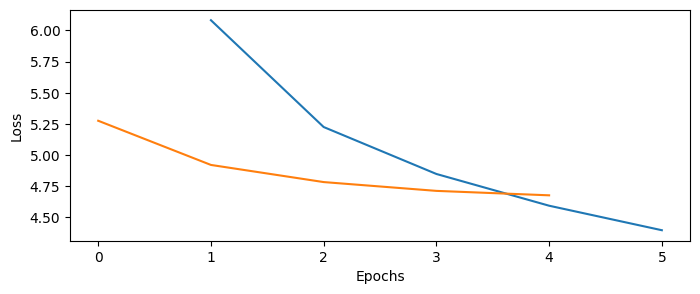

In [38]:
plt.figure(figsize=(8, 3))
plt.plot(
    [ep + 1 for ep in range(len(train_class_losses))],
    train_class_losses, val_class_losses,)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Evaluation

In [39]:
test_class_loss, test_accuracy, _, _ = loss_acc_loader(seq2seq, test_loader, device, force=0.5)

print(f"Test: Class Loss {test_class_loss:.4f}, Accuracy {test_accuracy*100:.2f}%")

Test: Class Loss 7.9169, Accuracy 12.02%


In [40]:
## With zero teacher_force
test_class_loss, test_accuracy, _, _ = loss_acc_loader(seq2seq, test_loader, device, force=0.0)

print(f"Test: Class Loss {test_class_loss:.4f}, Accuracy {test_accuracy*100:.2f}%")

Test: Class Loss 8.7059, Accuracy 10.42%


In [41]:
custom_test = "i am home."
preprocessed = preprocess_en(custom_test)
print(preprocessed)

en_tokens = torch.tensor(en_vocab(preprocessed)).unsqueeze(0).to(device)
print(en_tokens)

maxtries = 30
targets_hat = seq2seq.translate(en_tokens, maxtries)
print(targets_hat)
print(ar_vocab.tokens_to_text(targets_hat))

i am home .
tensor([[  2,  42, 199, 562,   9,   3]], device='cuda:0')
[2, 128, 279, 3]
<SOS> في المنزل <EOS>


### Saving

In [42]:
model_states = {
    "en_vocabulary": en_vocab.get_vocabulary(),
    "ar_vocabulary": ar_vocab.get_vocabulary()
}

torch.save(model_states, f"{base_dir}/seq2seq_with_attention_states.pt")

## Save Entire Model
torch.save(seq2seq, f"{base_dir}/seq2seq_with_attention.bin")